In [1]:
# Homework 5                                                                                                          
# Rotation Curves   
# William Lake

# import modules                                                                                                       
import numpy as np
import astropy.units as u
from ReadFile import Read
from CenterOfMass import CenterOfMass
import math
from matplotlib.pyplot import *
%matplotlib inline
from astropy.constants import G
G = G.to(u.kpc * u.km ** 2 / u.s ** 2 / u.Msun) # Converts the gravitational constant to our desired units

In [85]:
class MassProfile:
    
    def __init__(self, galaxy, snap):
        # This function/class takes the galaxy name and snapshot number as inputs
        
        # The following three lines create the part of the filename that describe the Snap number, and then generate the filename
        ilbl = '000' + str(snap)
        ilbl = ilbl[-3:]
        self.filename = "%s_"%(galaxy) + ilbl + '.txt'
        time, total, data = Read(self.filename) # Read the data
        self.x = np.array(data['x']) * u.kpc # Import the x, y, and z coordinates with correct units
        self.y = np.array(data['y']) * u.kpc
        self.z = np.array(data['z']) * u.kpc
        self.m = np.array(data['m']) # Import the mass data
        self.data = data # Wasn't asked for but useful later
        self.gname = galaxy # Stores galaxy name
        
    def distance(self, x1, x2, y1, y2, z1, z2):
        # This function describes the absolute distance between points (x1,y1,z1) and (x2, y2, z2)
        return np.sqrt(((x1 - x2) ** 2 + (y1 - y2) ** 2 + (z1 - z2) ** 2))
    
    def MassEnclosed(self, pType, rArray):
        # Takes as input the particle type and an array of radii
        # Returns the enclosed mass of that type of particle in the galaxy from each radius
        
        # First, we determine the COM position, as we did last week:
        COM_Object = CenterOfMass(self.filename, pType)
        X_COM, Y_COM, Z_COM = COM_Object.COM_P(1.0) # Finds the center of mass coordinates of the galaxy
        
        typeIndex = np.where(self.data['type'] == pType)
        
        Radii = self.distance(self.x, X_COM, self.y, Y_COM, self.z, Z_COM) 
        # Creates an array to hold distances of particles from the COM
        
        masses = np.zeros(len(rArray)) # Creates our result array
        
        for index in range(len(rArray)):
            # Loops over rArray to find enclosed mass
            indices = np.where(Radii[typeIndex] < rArray[index])
            masses[index] = sum(self.m[indices])
            
        return masses * u.Msun * 10 ** 10
    
    def MassEnclosedTotal(self, rArray):
        # Takes as input an array of radii
        # Returns the enclosed mass in the galaxy from each radius
        masses = np.zeros(len(rArray)) # Creates our result array
        for i in range(3):
            if(self.gname != 'M33' or i < 2):
                masses += self.MassEnclosed(i+1, rArray) # This adds the contributions of a given particle type to the total mass
                
        return masses * u.Msun

    def HernquistMass(self, radius, a, mHalo):
        # This function takes as input the radius, scale factor a, and Halo mass, and returns the enclosed mass in units M_sun
        return mHalo * (radius ** 2) / (a + radius) ** 2
    
    def CircularVelocity(self, pType, rArray):
        # Takes as input the particle type and an array of radii
        # Returns the velocity of a particle in circular orbit at each radius, due to the mass enclosed of type pType
        # The formula for this is based on a force balance, GM/r^2 = v^2 / r, v=Sqrt(GM/r)
        mass = self.MassEnclosed(pType, rArray)
        return np.around(np.sqrt(G * np.divide(mass, rArray)), decimals=2)
    
    def CircularVelocityTotal(self, rArray):
        # Takes as input an array of radii
        # Returns the velocity of a particle in circular orbit at each radius, due to the mass enclosed
        # The formula for this is based on a force balance, GM/r^2 = v^2 / r, v=Sqrt(GM/r)
        mass = self.MassEnclosedTotal(rArray)
        return np.around(np.sqrt(G * np.divide(mass, rArray)), decimals=2)
    
    def HernquistVCirc(self, radius, a, mHalo):
        # This function takes as input the radius, scale factor a, and Halo mass, and returns the Hernquist circular velocity
        mass = self.HernquistMass(radius, a, mHalo)
        return np.around(np.sqrt(G * np.divide(mass, radius)), decimals=2)

Text(0.5,1,'Radius vs Enclosed Mass, Milky Way')

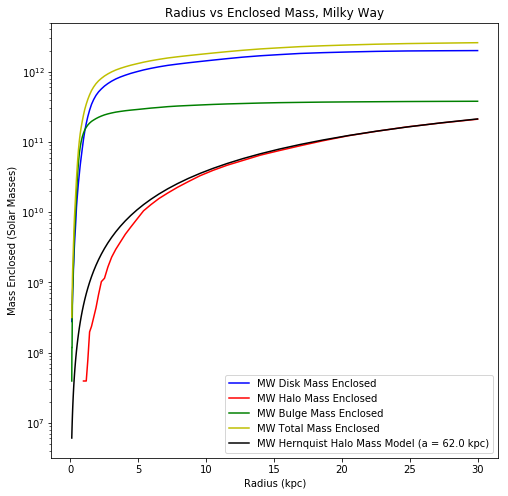

In [86]:
mp = MassProfile('MW', 0)

# This next block generates an array of radii to use in this plot
radiusArray = []
i = 30
while i > .1:
    radiusArray.append(i)
    i /= 1.1
radiusArray = np.array(radiusArray) * u.kpc

MWDisk = mp.MassEnclosed(2,radiusArray) # Array describing enclosed disk type masses in the Milky Way
MWHalo = mp.MassEnclosed(1,radiusArray) # Array describing enclosed halo type masses in the Milky Way
MWBulge = mp.MassEnclosed(3,radiusArray) # Array describing enclosed bulge type masses in the Milky Way
MWTotal = mp.MassEnclosedTotal(radiusArray) # Array describing enclosed total masses in the Milky Way

fig = figure(figsize=(8,8))
semilogy(radiusArray, MWDisk,'b', label = 'MW Disk Mass Enclosed')
semilogy(radiusArray, MWHalo,'r', label = 'MW Halo Mass Enclosed')
semilogy(radiusArray, MWBulge,'g', label = 'MW Bulge Mass Enclosed')
semilogy(radiusArray, MWTotal,'y', label = 'MW Total Mass Enclosed')

hMass = mp.HernquistMass(radiusArray, 62.0 * u.kpc, mp.MassEnclosed(2, np.array([100]) * u.kpc))
semilogy(radiusArray, hMass, color = "Black", label = 'MW Hernquist Halo Mass Model (a = 62.0 kpc)')

legend()
xlabel('Radius (kpc)')
ylabel('Mass Enclosed (Solar Masses)')
title('Radius vs Enclosed Mass, Milky Way')



Text(0.5,1,'Radius vs Enclosed Mass, M31')

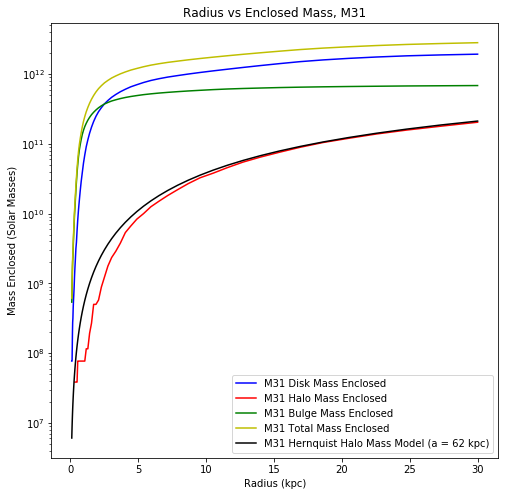

In [80]:
mp = MassProfile('M31', 0)

# This next block generates an array of radii to use in this plot
radiusArray = []
i = 30
while i > .1:
    radiusArray.append(i)
    i /= 1.1
radiusArray = np.array(radiusArray) * u.kpc

M31Disk = mp.MassEnclosed(2,radiusArray) # Array describing enclosed disk type masses in M31
M31Halo = mp.MassEnclosed(1,radiusArray) # Array describing enclosed halo type masses in M31
M31Bulge = mp.MassEnclosed(3,radiusArray) # Array describing enclosed bulge type masses in M31
M31Total = mp.MassEnclosedTotal(radiusArray) # Array describing enclosed total masses in M31

fig = figure(figsize=(8,8))
semilogy(radiusArray, M31Disk,'b', label = 'M31 Disk Mass Enclosed')
semilogy(radiusArray, M31Halo,'r', label = 'M31 Halo Mass Enclosed')
semilogy(radiusArray, M31Bulge,'g', label = 'M31 Bulge Mass Enclosed')
semilogy(radiusArray, M31Total,'y', label = 'M31 Total Mass Enclosed')

hMass = mp.HernquistMass(radiusArray, 62 * u.kpc, mp.MassEnclosed(2, np.array([100]) * u.kpc))
semilogy(radiusArray, hMass, color = "Black", label = 'M31 Hernquist Halo Mass Model (a = 62 kpc)')

legend()
xlabel('Radius (kpc)')
ylabel('Mass Enclosed (Solar Masses)')
title('Radius vs Enclosed Mass, M31')



Text(0.5,1,'Radius vs Enclosed Mass, M33')

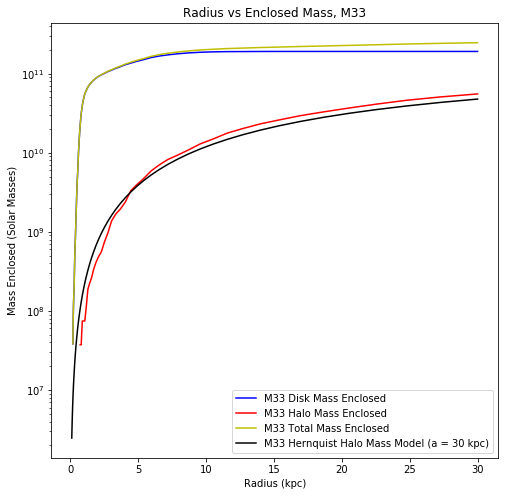

In [71]:
mp = MassProfile('M33', 0)

# This next block generates an array of radii to use in this plot
radiusArray = []
i = 30
while i > .1:
    radiusArray.append(i)
    i /= 1.1
radiusArray = np.array(radiusArray) * u.kpc

M33Disk = mp.MassEnclosed(2,radiusArray) # Array describing enclosed disk type masses in M33
M33Halo = mp.MassEnclosed(1,radiusArray) # Array describing enclosed halo type masses in M33
M33Total = mp.MassEnclosedTotal(radiusArray) # Array describing enclosed total masses in M33

fig = figure(figsize=(8,8))
semilogy(radiusArray, M33Disk,'b', label = 'M33 Disk Mass Enclosed')
semilogy(radiusArray, M33Halo,'r', label = 'M33 Halo Mass Enclosed')
semilogy(radiusArray, M33Total,'y', label = 'M33 Total Mass Enclosed')

hMass = mp.HernquistMass(radiusArray, 30 * u.kpc, mp.MassEnclosed(2, np.array([100]) * u.kpc))
semilogy(radiusArray, hMass, color = "Black", label = 'M33 Hernquist Halo Mass Model (a = 30 kpc)')

legend()
xlabel('Radius (kpc)')
ylabel('Mass Enclosed (Solar Masses)')
title('Radius vs Enclosed Mass, M33')


Text(0.5,1,'Radius vs Velocity, Milky Way')

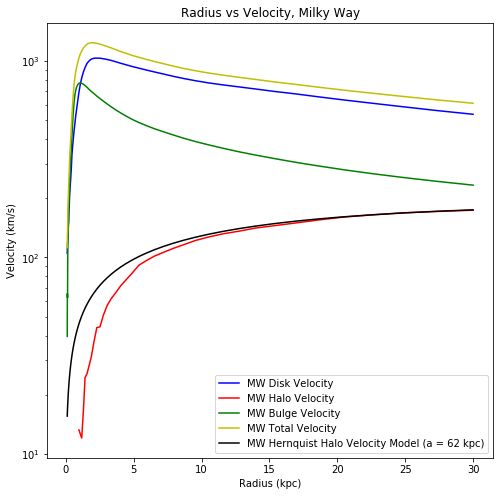

In [81]:
mp = MassProfile('MW', 0)

# This next block generates an array of radii to use in this plot
radiusArray = []
i = 30
while i > .1:
    radiusArray.append(i)
    i /= 1.1
radiusArray = np.array(radiusArray) * u.kpc

MWDisk = mp.CircularVelocity(2,radiusArray) # Array describing velocity at various radii in the disk of the Milky Way
MWHalo = mp.CircularVelocity(1,radiusArray) # Array describing velocity at various radii in the halo of the Milky Way
MWBulge = mp.CircularVelocity(3,radiusArray) # Array describing velocity at various radii in the bulge of the Milky Way
MWTotal = mp.CircularVelocityTotal(radiusArray) # Array describing velocity at various radii in the Milky Way

fig = figure(figsize=(8,8))
semilogy(radiusArray, MWDisk,'b', label = 'MW Disk Velocity')
semilogy(radiusArray, MWHalo,'r', label = 'MW Halo Velocity')
semilogy(radiusArray, MWBulge,'g', label = 'MW Bulge Velocity')
semilogy(radiusArray, MWTotal,'y', label = 'MW Total Velocity')

hMass = mp.HernquistVCirc(radiusArray, 62 * u.kpc, mp.MassEnclosed(2, np.array([100]) * u.kpc))
semilogy(radiusArray, hMass, color = "Black", label = 'MW Hernquist Halo Velocity Model (a = 62 kpc)')

legend()
xlabel('Radius (kpc)')
ylabel('Velocity (km/s)')
title('Radius vs Velocity, Milky Way')

Text(0.5,1,'Radius vs Velocity, M31')

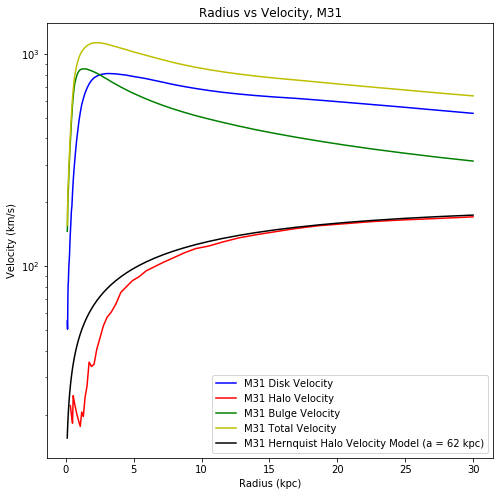

In [82]:
mp = MassProfile('M31', 0)

# This next block generates an array of radii to use in this plot
radiusArray = []
i = 30
while i > .1:
    radiusArray.append(i)
    i /= 1.1
radiusArray = np.array(radiusArray) * u.kpc

M31Disk = mp.CircularVelocity(2,radiusArray) # Array describing velocity at various radii in the disk of M31
M31Halo = mp.CircularVelocity(1,radiusArray) # Array describing velocity at various radii in the halo of M31
M31Bulge = mp.CircularVelocity(3,radiusArray) # Array describing velocity at various radii in the bulge of M31
M31Total = mp.CircularVelocityTotal(radiusArray) # Array describing velocity at various radii in M31

fig = figure(figsize=(8,8))
semilogy(radiusArray, M31Disk,'b', label = 'M31 Disk Velocity')
semilogy(radiusArray, M31Halo,'r', label = 'M31 Halo Velocity')
semilogy(radiusArray, M31Bulge,'g', label = 'M31 Bulge Velocity')
semilogy(radiusArray, M31Total,'y', label = 'M31 Total Velocity')

hMass = mp.HernquistVCirc(radiusArray, 62 * u.kpc, mp.MassEnclosed(2, np.array([100]) * u.kpc))
semilogy(radiusArray, hMass, color = "Black", label = 'M31 Hernquist Halo Velocity Model (a = 62 kpc)')

legend()
xlabel('Radius (kpc)')
ylabel('Velocity (km/s)')
title('Radius vs Velocity, M31')

Text(0.5,1,'Radius vs Velocity, M33')

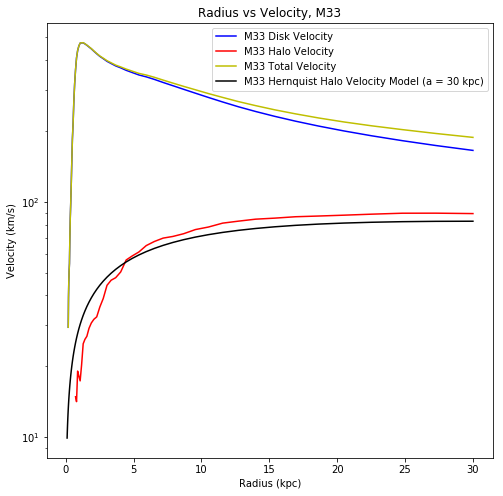

In [76]:
mp = MassProfile('M33', 0)

# This next block generates an array of radii to use in this plot
radiusArray = []
i = 30
while i > .1:
    radiusArray.append(i)
    i /= 1.1
radiusArray = np.array(radiusArray) * u.kpc

M33Disk = mp.CircularVelocity(2,radiusArray) # Array describing velocity at various radii in the disk of M33
M33Halo = mp.CircularVelocity(1,radiusArray) # Array describing velocity at various radii in the halo of M33
M33Total = mp.CircularVelocityTotal(radiusArray) # Array describing velocity at various radii in the M33

fig = figure(figsize=(8,8))
semilogy(radiusArray, M33Disk,'b', label = 'M33 Disk Velocity')
semilogy(radiusArray, M33Halo,'r', label = 'M33 Halo Velocity')
semilogy(radiusArray, M33Total,'y', label = 'M33 Total Velocity')

hMass = mp.HernquistVCirc(radiusArray, 30 * u.kpc, mp.MassEnclosed(2, np.array([100]) * u.kpc))
semilogy(radiusArray, hMass, color = "Black", label = 'M33 Hernquist Halo Velocity Model (a = 30 kpc)')

legend()
xlabel('Radius (kpc)')
ylabel('Velocity (km/s)')
title('Radius vs Velocity, M33')